In [589]:
# Импорт библиотек
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Настройки Pandas
pd.set_option('display.max_columns', None)

In [628]:
# Чтение датасета
df = pd.read_csv('../../data/_data.csv')

In [591]:
# Удаляем столбец `Unnamed: 0`
df = df.iloc[:, 1:]

# Переименовываем столбцы
NEW_COLUMNS = {
    'ID  объявления':           'id',
    'Количество комнат':        'rooms',
    'Тип':                      'type',
    'Метро':                    'metro_station',
    'Адрес':                    'address',
    'Площадь, м2':              'area',
    'Дом':                      'building_type',
    'Парковка':                 'parking',
    'Цена':                     'price',
    'Телефоны':                 'phones',
    'Описание':                 'description',
    'Ремонт':                   'renovation',
    'Площадь комнат, м2':       'rooms_area',
    'Балкон':                   'balcony',
    'Окна':                     'windows',
    'Санузел':                  'bathroom',
    'Можно с детьми/животными': 'kids_pets',
    'Дополнительно':            'extra',
    'Название ЖК':              'complex_title',
    'Серия дома':               'building_series',
    'Высота потолков, м':       'ceiling_height',
    'Лифт':                     'elevator',
    'Мусоропровод':             'trash_chute',
    'Ссылка на объявление':     'listing_url',
}
df = df.rename(columns=NEW_COLUMNS)

In [592]:
# исключим из исходного датасета г. Санкт-Петербург
df = df[~df["address"].str.contains('етербург')]

### Колонка `rooms`

In [593]:
# Создаем столбец `num_rooms` с кол-ом комнат
df['num_rooms'] = df['rooms'].str.extract(r'(\d+)').astype(float)

### Колонка `metro_station`

In [594]:
def extract_numbers(metro_station):
    if isinstance(metro_station, str): #проверяем на отсутствие Nun
        match = re.search(r'\d+', metro_station) #узнаем числа в ячейке
        if match:
            return int(match.group(0))
    return np.nan
df['time_to_metro'] = df['metro_station'].apply(extract_numbers)
mean_value = round(df['time_to_metro'].mean())
df['time_to_metro'].replace('', mean_value, inplace=True)

In [595]:
# Выделим из колонки `metro_station` сведения о времени до метро
pattern = r"\((\d+)\s*мин"
minutes_str = df['metro_station'].str.extract(pattern, expand=False)
df['time_to_metro'] = pd.to_numeric(minutes_str, errors="coerce")

### Колонка `area`

In [596]:
# Добавляем столбец с общей площадью квартир
df['total_area'] = df['area'].str.split('/').str[0].astype('float')

### Колонка `building_type`

In [597]:
# Добавляем столбец `floor` с номером этажа и `total_floors` с этажностью здания
df['floor'] = df['building_type'].str.extract(r'(\d{1,3})/').astype(float)
df['total_floors'] = df['building_type'].str.extract(r'/(\d{1,3})').astype(float)
df['parking'].unique()

array(['подземная', nan, 'наземная', 'открытая', 'многоуровневая',
       'на крыше'], dtype=object)

### Колонка `parking`

In [598]:
# категоризовываем колонку `parking` в колонку `parking_categories` от 0 до 5
df['parking'].fillna('нет', inplace=True)
df['parking_categories'] = pd.factorize(df['parking'])[0]

### Столбец `Price`

In [599]:
# Создаем столбец с главной ценой
# r'([\d\.]+)' Это регулярное выражение, которое используется для поиска чисел с точкой. 
# \d — означает любую цифру от 0 до 9. 
# [\d\.]+ — это: «одна или больше цифр и/или точек подряд». 
df['main_price'] = df['price'].str.extract(r'([\d\.]+)').astype(float)

# Коммунальные услуги - выводим 1 если True и 0 если False
df['utilities_included'] = df['price'].str.contains('Коммунальные услуги включены', case=False, na=False).astype(int)


# Срок аренды
# Ищем слово Срок аренды, дефис, и слова после него
df['rental_term'] = df['price'].str.extract(r'Срок аренды\s*-\s*([а-яА-Яa-zA-Z ]+)')[0].str.strip().map({'Длительный': 1, 'На несколько месяцев': 0})

# Предоплата
# Ищем слово Предоплата, дефис, и слова после него
df['prepayment_months'] = df['price'].str.extract(r'Предоплата\s*(\d+)')
df['prepayment_months'] = df['prepayment_months'].astype(float).astype(float).fillna(0)

### Столбец `balcony`

In [600]:
# Добавляем столбец `presence_balcony` с информацией 0 - балконов/лоджий нет, 1 - балкон/лоджия есть
def extract_numbers(balcony):
    if isinstance(balcony, str): # проверяем на отсутвтвие Nun 
        return int(1)
    else:
        return int(0)
df['presence_balcony'] = df['balcony'].apply(extract_numbers)

### Столбец `bathroom`

In [601]:
# Добавляем столбец `numbers_toilets` с информацией о кол-ве санузлов
def numbers_toilet(bathroom):
    if isinstance(bathroom, str): #проверяем на отсутвтвие Nun 
        numbers = re.findall(r'\d+', bathroom)
        return sum(int(num) for num in numbers)
    else:
        return int(1)
df['numbers_toilets'] = df['bathroom'].apply(numbers_toilet)

### Столбец `kids_pets`

In [602]:
# Добавляем столбец `kids_allowed` с информацией допустима ли аренда с детьми
df['kids_allowed'] = np.where(df['kids_pets'].str.contains('детьми'), 1, 0)
# Добавляем столбец `pets_allowed` с информацией допустима ли аренда с животными
df['pets_allowed'] = np.where(df['kids_pets'].str.contains('животными'), 1, 0)

### Столбец `extra`

In [603]:
# добавляем столбец с наличием/отсутствием мебели
df["furniture"] = np.where(df["extra"].str.contains('Мебель в комнатах'), 1, 0)
# добавляем столбец с наличием/отсутствием холодильника
df["fridge"] = np.where(df["extra"].str.contains('Холодильник'), 1, 0)
# добавляем столбец с наличием/отсутствием стиральной машины
df["washing_machine"] = np.where(df["extra"].str.contains('Стиральная машина'), 1, 0)
df["condi"] = np.where(df["extra"].str.contains('Кондиционер'), 1, 0)
df["fur_in_kitch"] = np.where(df["extra"].str.contains('Мебель на кухне'), 1, 0)

### Столбец `ceiling_height`

In [604]:
# Заполняем пропущенные значения в столбце `ceiling_height` медианой
df.fillna({'ceiling_height': (df['ceiling_height'].median())}, inplace=True)

### Столбец `elevator`

In [605]:
# Вытащим из строк информацию о количестве лифтов
df['elevator_num'] = df['elevator'].str.extract(r'(\d{1,2})\).*(\d{1,2})\).*|(\d{1,2})\)').astype(float).sum(axis=1, min_count=1).fillna(0)

# Удаление неиспользуемых столбцов и очистка пропусков

In [606]:
del_list = [
    'rooms_area', 'balcony', 'windows', 'bathroom', 'kids_pets', 'extra', 'complex_title', 'building_series', 'elevator','trash_chute'
    ]
df.drop(del_list, axis = 1, inplace = True)
df.dropna(inplace=True)
# сбросим индекс
df = df.reset_index(drop=True)

# Очистка аномалий, поиск выбросов

### Колонка `price`

In [607]:
# Удалим объявления с продажей квартир за валюту
df = df[~df['price'].str.contains(r'\$|\€')]

### Колонка `ceiling_height`

count    15850.000000
mean         2.811574
std          5.517169
min          1.200000
25%          2.640000
50%          2.640000
75%          2.640000
max        320.000000
Name: ceiling_height, dtype: float64


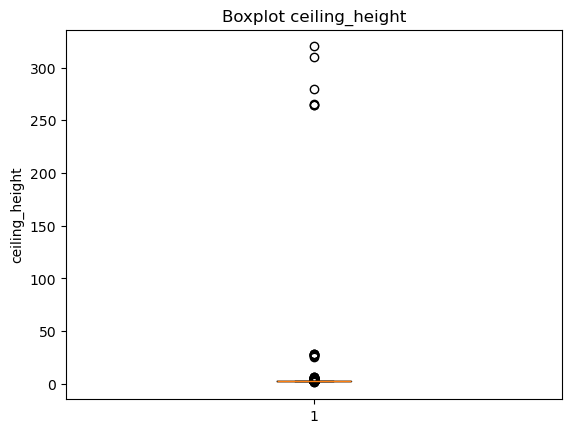

In [608]:
# рассмотрим распределение значений в столбце `ceiling_height` и построим `boxplot`
print(df['ceiling_height'].describe())
plt.boxplot(df['ceiling_height'].dropna())
plt.title('Boxplot ceiling_height')
plt.ylabel('ceiling_height')
plt.show();

In [609]:
# постараемся найти значения, выходящие за рамки логически возможных
df.query('ceiling_height > 5 or ceiling_height < 2')['ceiling_height'].unique().tolist()

[310.0, 28.0, 264.0, 27.0, 26.0, 6.0, 265.0, 320.0, 25.0, 280.0, 1.2]

In [610]:
# заменим ошибочно введенные данные на верные
replace_dict = {
    310.0: 3.1,
    28.0: 2.8,
    264.0: 2.64,
    27.0: 2.7,
    26.0: 2.6,
    265.0: 2.65,
    320.0: 3.2,
    25.0: 2.5,
    280.0: 2.8
}

df['ceiling_height'] = df['ceiling_height'].replace(replace_dict)

# удалим 5 строк с аномальными значениями
df = df[(df['ceiling_height'] <= 5) & (df['ceiling_height'] >= 2)]

## Колонка `total_area`

count    15846.000000
mean        63.839243
std         46.525134
min          7.000000
25%         39.000000
50%         50.000000
75%         69.000000
max        811.000000
Name: total_area, dtype: float64


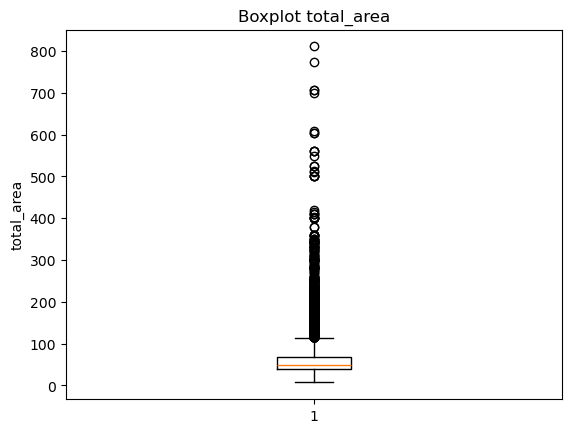

In [611]:
# рассмотрим значение колонки `total area`
print(df['total_area'].describe())
plt.boxplot(df['total_area'].dropna())
plt.title('Boxplot total_area')
plt.ylabel('total_area')
plt.show()

In [612]:
# в целях нормальной настройки модели исключим из датасета все объекты с площадью более 300 м2
df = df.query('total_area < 300')

In [613]:
# исключим все строки с `elevator_num` > 10
df = df.query('elevator_num < 10')

In [ ]:
# Сохранение промежуточного датасета
#df.to_csv('../release 2.0/data.csv', index=False)

# Визуализация

## Влияние удаленности до метро и наличия парковки на стоимость объекта недвижимости

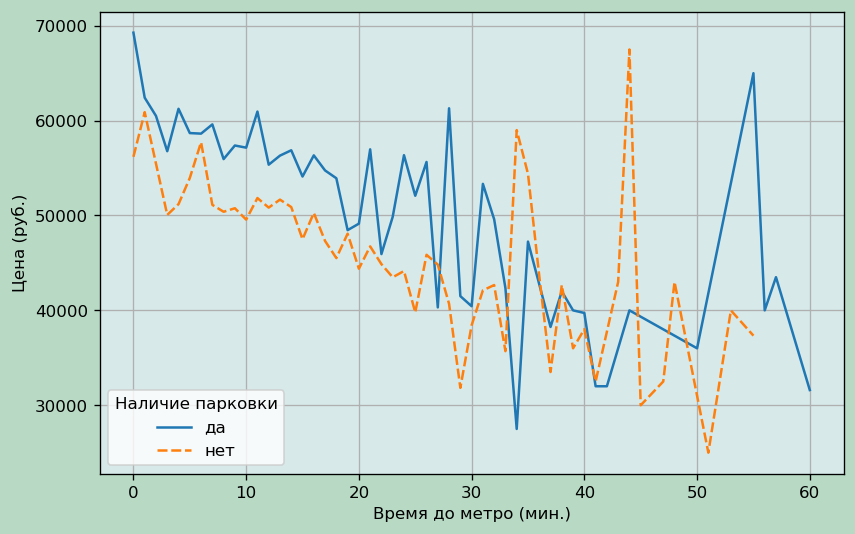

In [615]:
# Строим график
df_park_tm = df[(df['main_price'] < 150_000) & (df['time_to_metro'] <= 60)]
df_park_tm = df_park_tm[df_park_tm['address'].str.contains('осква')]
df_park_tm['parking_avalible'] = np.where(df_park_tm['parking'] == 'нет', 'нет', 'да')
table = pd.pivot_table(df_park_tm, values='main_price', index='time_to_metro', 
                        columns='parking_avalible', aggfunc='mean')

fig, ax = plt.subplots(figsize=(8, 5), dpi=120)
fig.set_facecolor("#b8dac5")
ax.set_facecolor("#D7E9E9")

sns.lineplot(table)
plt.xlabel('Время до метро (мин.)')
plt.ylabel('Цена (руб.)')
plt.grid()
legend = plt.legend()
legend.set_title("Наличие парковки")
plt.show()

## Распределение средней стоимости квартиры в зависимости от возможности аренды с животными

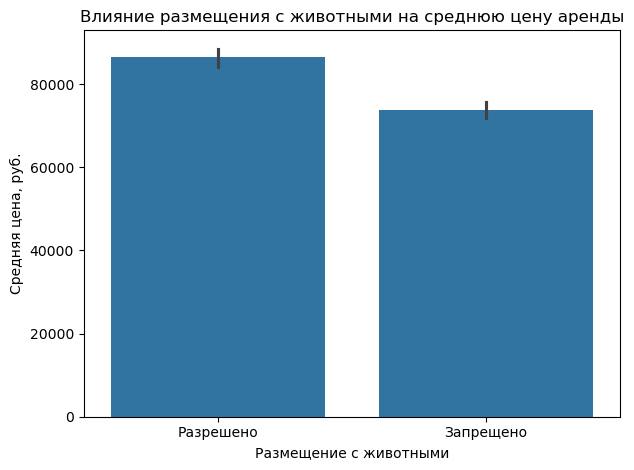

In [616]:
# Создаём копию столбца с заменой значений
df['pets_allowed_label'] = df['pets_allowed'].map({0: 'Запрещено', 1: 'Разрешено'})

# Строим график
sns.barplot(x='pets_allowed_label', y='main_price', data=df)


plt.xlabel('Размещение с животными')
plt.ylabel('Средняя цена, руб.')
plt.title('Влияние размещения с животными на среднюю цену аренды')

plt.tight_layout()
plt.show()

#### Вывод: В среднем квартиры, где разрешены животные, стоят дороже

# Распределение средней стоимости на квартиру в зависимости от возможности арендовать с детьми

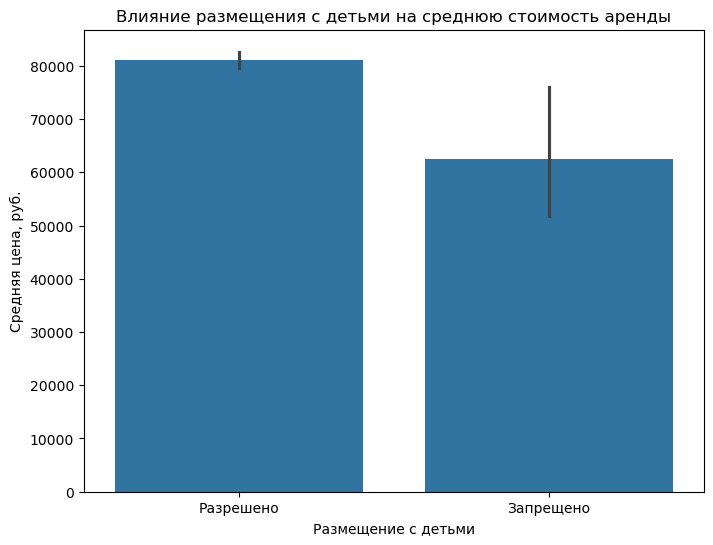

In [617]:
# Создаем копию датасета с заменой значений 0/1 на текст
df_kids = df.copy()
df_kids['kids_allowed'] = df_kids['kids_allowed'].replace({0: 'Запрещено', 1: 'Разрешено'})

# Строим график
plt.figure(figsize=(8, 6))
sns.barplot(x='kids_allowed', y='main_price', data=df_kids)

# Подписи
plt.xlabel('Размещение с детьми')
plt.ylabel('Средняя цена, руб.')
plt.title('Влияние размещения с детьми на среднюю стоимость аренды')
plt.show()

#### Вывод: в среднем квартиры, где разрешено размещение с детьми, стоят дороже.

# Зависимость стоимость квартиры от площади в разрезе количества комнат

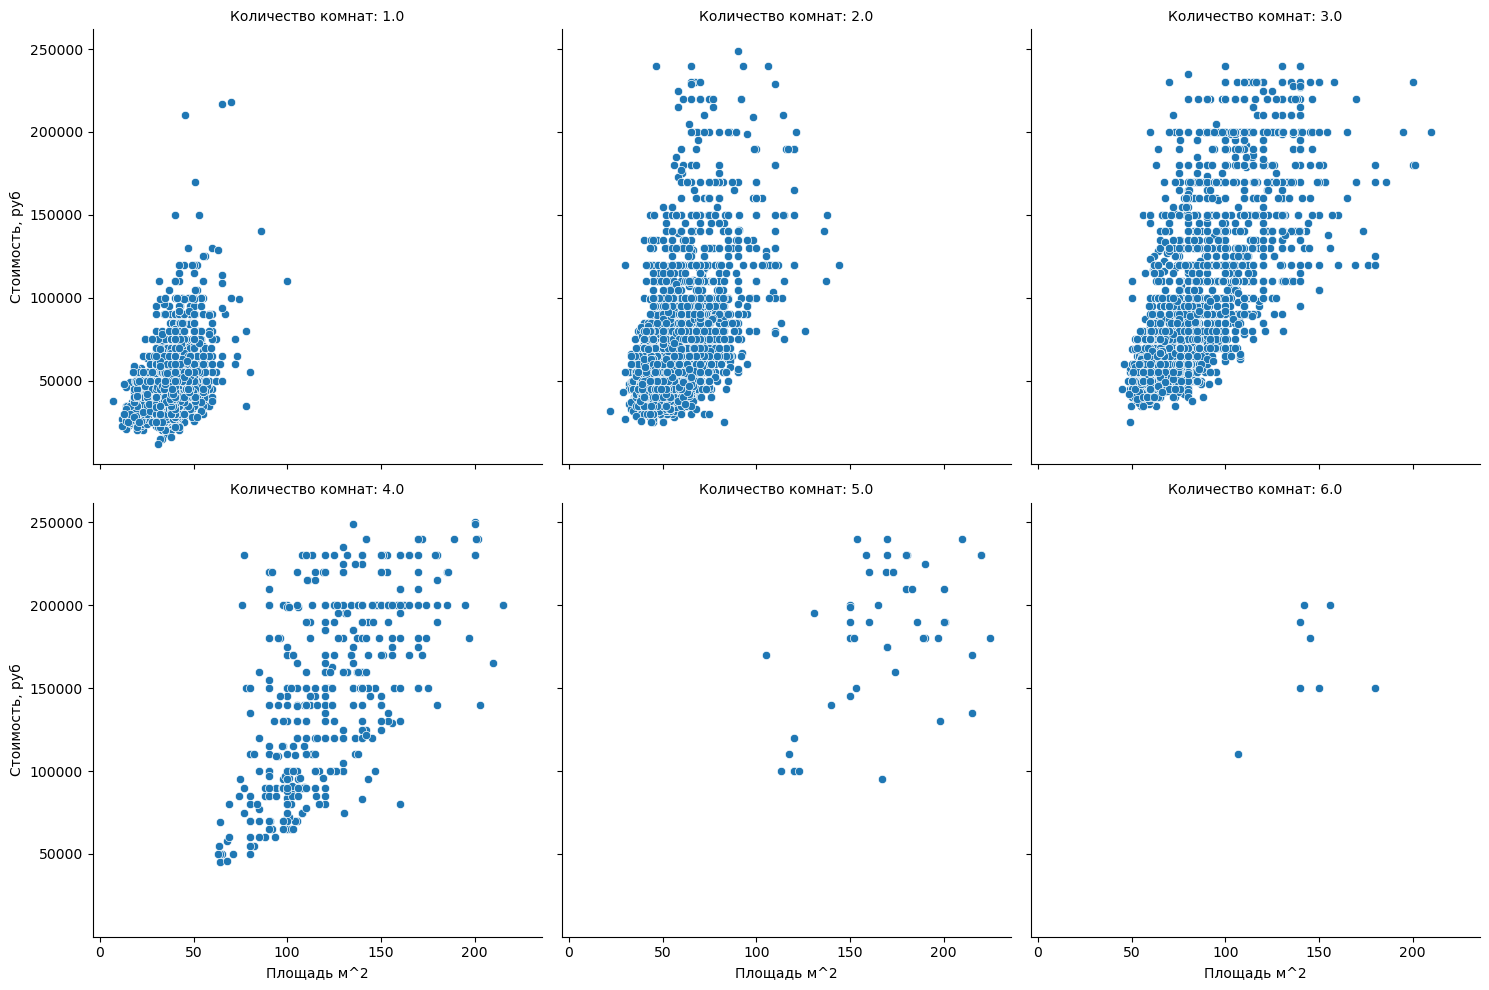

In [618]:
df_for_scatterplot = df.query('main_price < 250000')
num_cols = 3
g = sns.FacetGrid(df_for_scatterplot, col='num_rooms', height=5, aspect=1, col_wrap=num_cols)
g.map(sns.scatterplot, 'total_area', 'main_price')
g.set_axis_labels('Площадь м^2', 'Стоимость, руб')
g.set_titles(col_template='Количество комнат: {col_name}')
plt.show()

#### Вне зависимости от кол-ва комнат, прослеживается корреляция между площадью квартиры и ее стоимостью

# Столбчатый график, показывающий количество объявлений на каждый тип квартир (по комнатам)

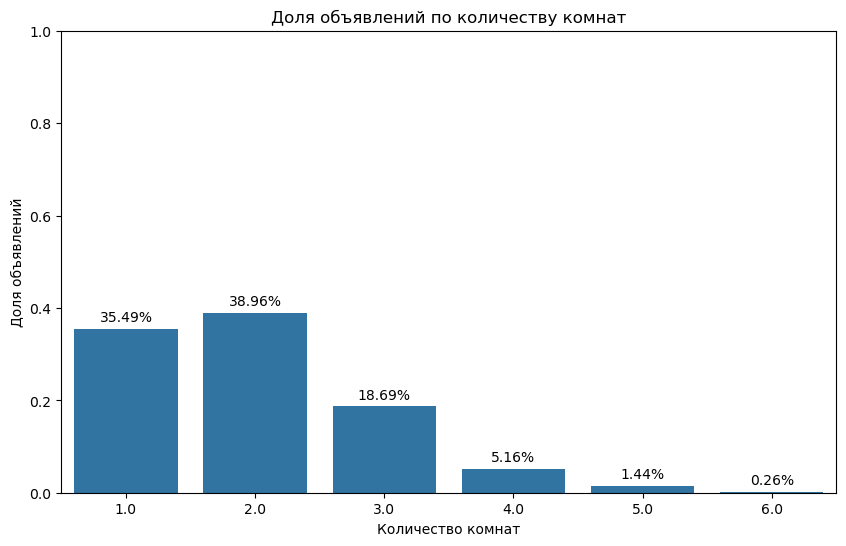

In [619]:
room_shares = df['num_rooms'].value_counts(normalize=True).sort_index()

plt.figure(figsize=(10, 6))
ax = sns.barplot(x=room_shares.index, y=room_shares.values)
plt.title('Доля объявлений по количеству комнат')
plt.xlabel('Количество комнат')
plt.ylabel('Доля объявлений')
plt.ylim(0, 1)

# Добавляем подписи
for i, v in enumerate(room_shares.values):
    plt.text(i, v + 0.01, f"{v:.2%}", ha='center', va='bottom', fontsize=10)

plt.show()

#### Вывод: наибольшую долю на рынке составляют однокомнатные и двухкомнатные квартиры (более 70%)

# Диаграмма рассеяния между площадью и ценой

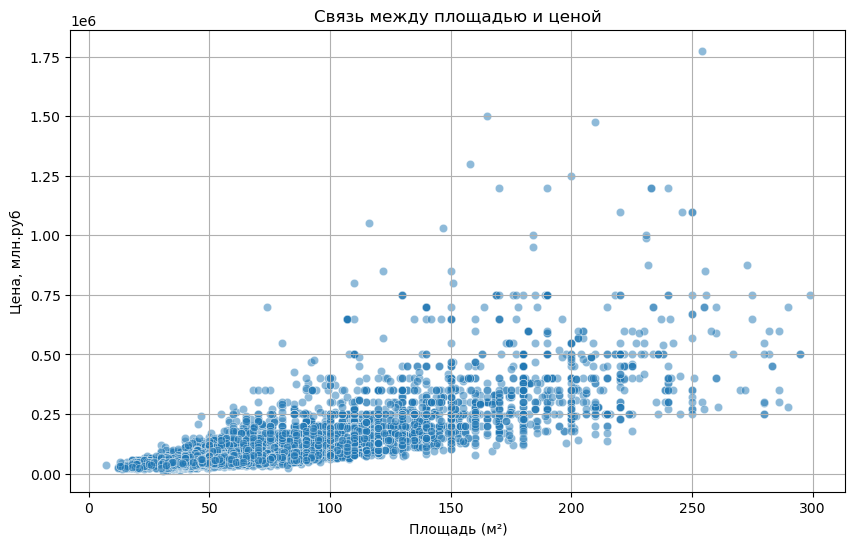

In [620]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='total_area', y='main_price', data=df, alpha=0.5)
plt.title('Связь между площадью и ценой')
plt.xlabel('Площадь (м²)')
plt.ylabel('Цена, млн.руб')
plt.grid(True)
plt.show()

#### Вывод: прослеживается прямая взаимосвязь между площадью квартиры и стоимостью ее аренды

## Тепловая карта корреляции основных признаков со стоимостью квартиры

Text(0.5, 1.0, 'Корреляция числовых признаков')

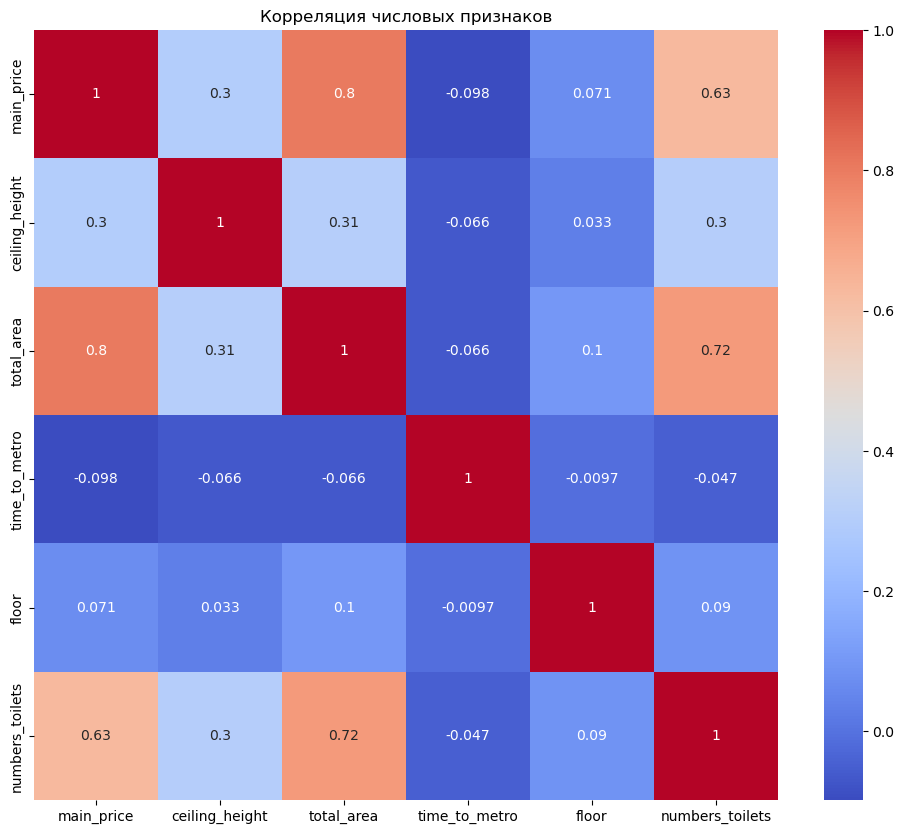

In [622]:
plt.figure(figsize=(12, 10))
sns.heatmap(df[['main_price', 'ceiling_height', 'total_area', 'time_to_metro', 'floor', 'numbers_toilets']].corr(numeric_only=True), annot=True, cmap='coolwarm')
plt.title('Корреляция числовых признаков')

#### Вывод: наиболее сильное влиянее на стоимость квартиры оказывает ее общая площадь

# Подготовка итогового датасета для обучения

In [623]:
# Удаляем колонки с типом `object` для обучающей модели
del_list2 = [
    'rooms', 'type', 'metro_station', 'address', 'area', 'building_type', 'parking', 'price', 'phones','description', 'renovation', 'listing_url', 'pets_allowed_label'
    ]
df_final = df.drop(del_list2, axis = 1)

In [624]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15746 entries, 0 to 15865
Data columns (total 22 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  15746 non-null  int64  
 1   ceiling_height      15746 non-null  float64
 2   num_rooms           15746 non-null  float64
 3   time_to_metro       15746 non-null  float64
 4   total_area          15746 non-null  float64
 5   floor               15746 non-null  float64
 6   total_floors        15746 non-null  float64
 7   parking_categories  15746 non-null  int64  
 8   main_price          15746 non-null  float64
 9   utilities_included  15746 non-null  int64  
 10  rental_term         15746 non-null  int64  
 11  prepayment_months   15746 non-null  float64
 12  presence_balcony    15746 non-null  int64  
 13  numbers_toilets     15746 non-null  int64  
 14  kids_allowed        15746 non-null  int64  
 15  pets_allowed        15746 non-null  int64  
 16  furniture

In [625]:
# Проверка на наличие пустых значений в ячейках
df_final.isna().sum()

id                    0
ceiling_height        0
num_rooms             0
time_to_metro         0
total_area            0
floor                 0
total_floors          0
parking_categories    0
main_price            0
utilities_included    0
rental_term           0
prepayment_months     0
presence_balcony      0
numbers_toilets       0
kids_allowed          0
pets_allowed          0
furniture             0
fridge                0
washing_machine       0
condi                 0
fur_in_kitch          0
elevator_num          0
dtype: int64

In [626]:
# Проверка на наличие явных строк-дубликатов
df_final.duplicated().sum()

np.int64(0)

In [ ]:
# Сохранение итогового датасета для работы модели
#df_final.to_csv('discovery_data.csv', index=False)